# Fake News Classification

This tutorial will go over classification of articles as fake or not.

In [1]:
import pandas as pd
import tensorflow as tf
import string
import keras
from keras import layers
from tensorflow.keras import layers
from tensorflow.keras import losses
import nltk


This is our training dataset, which we save as a pandas dataframe

In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [3]:
trainData = pd.read_csv(train_url)

In [4]:
trainData

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
...,...,...,...,...
22444,10709,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,1
22445,8731,Can Pence's vow not to sling mud survive a Tru...,"() - In 1990, during a close and bitter congre...",0
22446,4733,Watch Trump Campaign Try To Spin Their Way Ou...,A new ad by the Hillary Clinton SuperPac Prior...,1
22447,3993,"Trump celebrates first 100 days as president, ...","HARRISBURG, Pa.U.S. President Donald Trump hit...",0


We want to remove "stopwords" from the text, which we will do by removing words that are in the set of english stopwords from the nltk package.

In [5]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


here we write a function to make a Dataset where the title and text are in separate columns, and are free of any "stopwords"

In [6]:
def make_dataset(df):
    #
    df["title"] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #
    df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


    data = tf.data.Dataset.from_tensor_slices((
    #input dictionary
    { "title": df[["title"]],
     "text": df["text"]},

    #output dictionary
    { "fake": df[["fake"]]}
    ))
    return data.batch(100) #we use batch to make the program run faster

There are a total of 225 articles in our dataset.

In [7]:
dataset = make_dataset(trainData)

In [8]:
dataset_size = len(dataset)
print(dataset_size)

225


# Split Dataset
20% of the dataset is reserved for validation dataset

We reserve 20% of the dataset to be used to validate our training. This will help with overfitting and improving our model.

In [9]:
import random

dataset = dataset.shuffle(buffer_size = dataset_size)

val_size  = int(dataset_size * 0.2)

val = dataset.take(val_size)
train = dataset.skip(val_size).take(dataset_size - val_size)

#check size of training and validation sets
print(len(train), len(val))

180 45


# Base Model

In [10]:

labels_iterator= train.unbatch().map(lambda input, output: output).as_numpy_iterator()
fake = 0
real = 0
for i in labels_iterator:
    if i['fake'] == 1:
        fake +=1
    else:
        real +=1
print(f"{fake} fake and {real} real")
print(f"total sample is {real + fake}")
print(f"Our base rate of fake articles is {fake*100/(fake+real)}%")

9401 fake and 8548 real
total sample is 17949
Our base rate of fake articles is 52.37617694579085%


# Create Models

We will create 3 models, one using only the title, one using only the text, and one that combines both

In [11]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import re
import string



We prepare a vectorization layer with standardization for both title and vector.

In [12]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))


text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

### Model 1: Title

All models in this will require:
  an input: what will be inputted into the model
  model features: what features will be used to make an output
  an output: the classes which an output could be


First, we make our Input. In this case, it will be "titles" in string form



In [13]:
# inputs

title_input = keras.Input(
    shape = (1,),
    name = "title",
    dtype = "string"
)

These will be the layers we will be using in our model

In [14]:
title_features = title_vectorize_layer(title_input)
title_features = layers.Embedding(size_vocabulary, 3, name = "embedding1")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

finally, this is our output layer: 2 classes, fake or not fake as a function of **title_features**


In [15]:
output = layers.Dense(2, name = "fake")(title_features)

We put these together to make our first model

In [16]:
model1 = keras.Model(
    inputs = title_input,
    outputs = output
)

We can see using the **summary** method what layers will be used

In [17]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding1 (Embedding)      (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (  (None, 3)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0     

Here is an alternative visualization of the layers in order

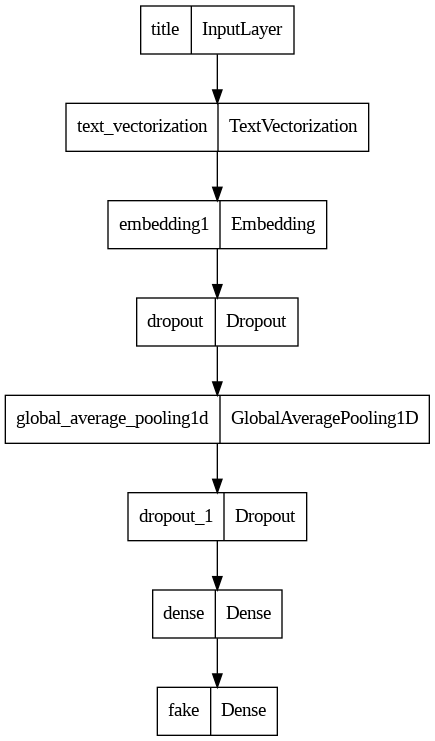

In [18]:
from tensorflow.keras import utils
utils.plot_model(model1)

Finally, we compile and then fit our model based on accuracy.

In [19]:
model1.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)


In [20]:
history1 = model1.fit(train, validation_data=val, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 19s 72ms/step - loss: 0.6919 - accuracy: 0.5218 - val_loss: 0.6909 - val_accuracy: 0.5211
Epoch 2/20
180/180 [==============================] - 2s 8ms/step - loss: 0.6846 - accuracy: 0.5450 - val_loss: 0.6722 - val_accuracy: 0.5249
Epoch 3/20
180/180 [==============================] - 1s 6ms/step - loss: 0.6317 - accuracy: 0.7700 - val_loss: 0.5688 - val_accuracy: 0.9029
Epoch 4/20
180/180 [==============================] - 1s 6ms/step - loss: 0.4880 - accuracy: 0.9006 - val_loss: 0.3978 - val_accuracy: 0.9296
Epoch 5/20
180/180 [==============================] - 1s 6ms/step - loss: 0.3447 - accuracy: 0.9289 - val_loss: 0.2758 - val_accuracy: 0.9411
Epoch 6/20
180/180 [==============================] - 1s 6ms/step - loss: 0.2577 - accuracy: 0.9401 - val_loss: 0.2075 - val_accuracy: 0.9528
Epoch 7/20
180/180 [==============================] - 1s 6ms/step - loss: 0.2056 - accuracy: 0.9480 - val_loss: 0.1598 - val_accuracy: 0.9622
Epoch 8/20
180/

Now that the model is finished, lets plot our results

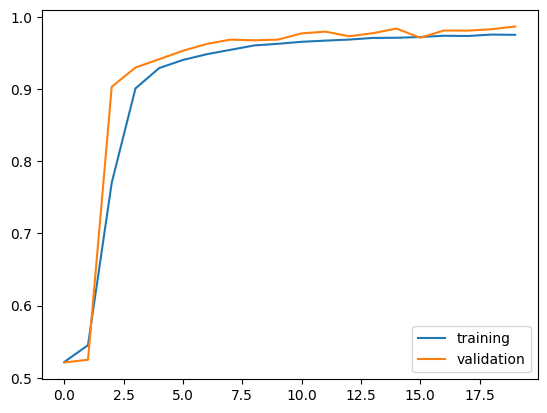

In [21]:
from matplotlib import pyplot as plt
plt.plot(history1.history["accuracy"],label='training')
plt.plot(history1.history["val_accuracy"],label='validation')
plt.legend()

It seems like we are around 97% accurate, with both the validation and actual accuracy around the same. This is pretty good with just the title.

### Model2: Text

This model will be made the exact same way, with the only difference being the input with "text" instead of "title"

In [22]:

text_input = keras.Input(
    shape = (1,),
    name = "text",
    dtype = "string"
)

text_features = text_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, 3, name = "embedding2")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)
output = layers.Dense(2, name = "fake")(text_features)



model2 = keras.Model(
    inputs = text_input,
    outputs = output
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding2 (Embedding)      (None, 500, 3)            6000      
                                                                 
 dropout_2 (Dropout)         (None, 500, 3)            0         
                                                                 
 global_average_pooling1d_1  (None, 3)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0   

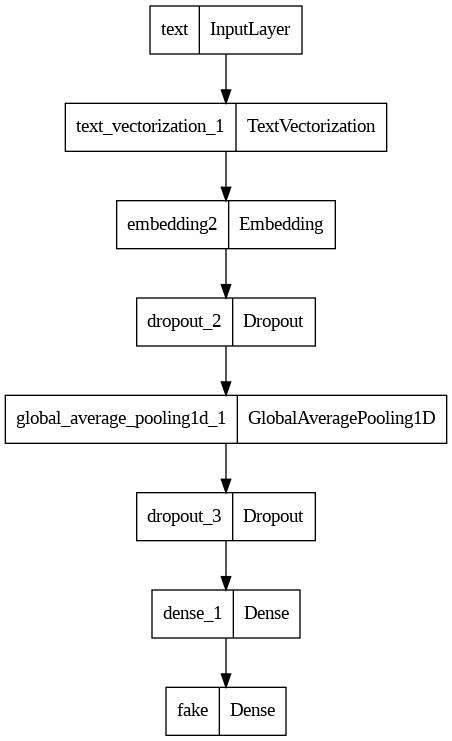

In [23]:
utils.plot_model(model2)

In [24]:
model2.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)


In [25]:
history2 = model2.fit(train, validation_data=val, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 16s 82ms/step - loss: 0.6785 - accuracy: 0.5607 - val_loss: 0.6310 - val_accuracy: 0.6409
Epoch 2/20
180/180 [==============================] - 6s 32ms/step - loss: 0.4957 - accuracy: 0.8665 - val_loss: 0.3523 - val_accuracy: 0.9107
Epoch 3/20
180/180 [==============================] - 4s 20ms/step - loss: 0.2938 - accuracy: 0.9227 - val_loss: 0.2294 - val_accuracy: 0.9433
Epoch 4/20
180/180 [==============================] - 2s 11ms/step - loss: 0.2174 - accuracy: 0.9442 - val_loss: 0.1841 - val_accuracy: 0.9509
Epoch 5/20
180/180 [==============================] - 2s 11ms/step - loss: 0.1806 - accuracy: 0.9542 - val_loss: 0.1487 - val_accuracy: 0.9620
Epoch 6/20
180/180 [==============================] - 2s 12ms/step - loss: 0.1573 - accuracy: 0.9578 - val_loss: 0.1309 - val_accuracy: 0.9644
Epoch 7/20
180/180 [==============================] - 2s 12ms/step - loss: 0.1405 - accuracy: 0.9616 - val_loss: 0.1105 - val_accuracy: 0.9733
Epoch 8/2

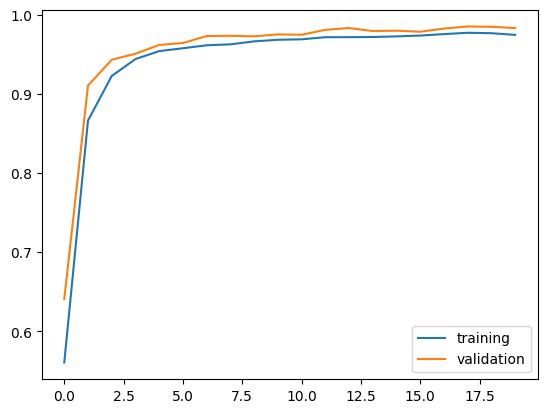

In [26]:
plt.plot(history2.history["accuracy"],label='training')
plt.plot(history2.history["val_accuracy"],label='validation')
plt.legend()

After running the model, it similar to slightly better than the title model. Still, the validation and training accuracies are rather similar.

# Model 3: Combined text and title

This time, we will combine our layers from model1 and model2 using the **concatenate** method. Then we will repeat the proceess once more.


In [27]:
combined = layers.concatenate([title_features, text_features], axis = 1)
combined = layers.Dense(4, activation='relu')(combined)
output = layers.Dense(4, name="fake")(combined)

In [28]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)
model3.summary()
utils.plot_model(model2)
model3.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
history3 = model3.fit(train, validation_data=val, epochs=20)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 text (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 500)                  0         ['title[0][0]']               
 ctorization)                                                                                     
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['text[0][0]']          

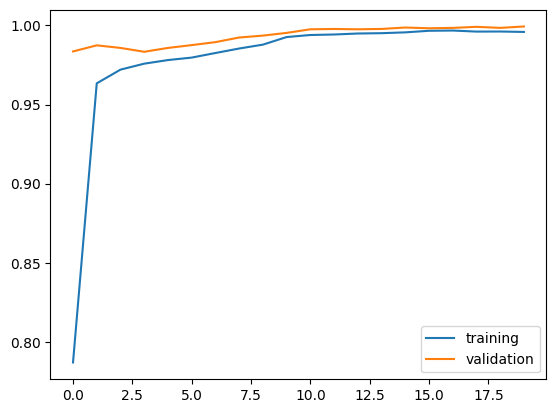

In [29]:
plt.plot(history3.history["accuracy"],label='training')
plt.plot(history3.history["val_accuracy"],label='validation')
plt.legend()

All 3 models have a very high score, of around 97-98%, however the model3, using both the text and title was most accurate, hovering at around 98%

# Evaluate Model

Now we test on a brand new dataset of articles to check how well our model performs.

In [30]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
testData = pd.read_csv(test_url)
testData

,Unnamed: 0,title,text,fake
0,420,"CNN And MSNBC Destroy Trump, Black Out His Fa...",Donald Trump practically does something to cri...,1
1,14902,Exclusive: Kremlin tells companies to deliver ...,The Kremlin wants good news. The Russian lead...,0
2,322,Golden State Warriors Coach Just WRECKED Trum...,"On Saturday, the man we re forced to call Pre...",1
3,16108,"Putin opens monument to Stalin's victims, diss...",President Vladimir Putin inaugurated a monumen...,0
4,10304,BREAKING: DNC HACKER FIRED For Bank Fraud…Blam...,Apparently breaking the law and scamming the g...,1
...,...,...,...,...
22444,20058,U.S. will stand be steadfast ally to Britain a...,The United States will stand by Britain as it ...,0
22445,21104,Trump rebukes South Korea after North Korean b...,U.S. President Donald Trump admonished South K...,0
22446,2842,New rule requires U.S. banks to allow consumer...,U.S. banks and credit card companies could be ...,0
22447,22298,US Middle Class Still Suffering from Rockefell...,Dick Eastman The Truth HoundWhen Henry Kissin...,1


In order to evaluate our model, we use the **evalutate** model, with the new dataset as a parameter

In [31]:
test_evaluate = model3.evaluate(make_dataset(testData))

225/225 [==============================] - 2s 9ms/step - loss: 0.0193 - accuracy: 0.9942


Per our evaluation, this model will predict a fake article 97% of the time

# Visualize Embeddings

Lets visualize the individual words and see how they contributed to an article's score.

In [32]:
weights = model2.get_layer('embedding2').get_weights()[0] # get the weights from the embedding layer
vocab = text_vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [33]:
import plotly.express as px
import numpy as np

import plotly.io as pio
pio.renderers.default="iframe"


fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 5,
                 hover_name = "word")

fig.show()

In the graph, word "GOP" is the furthest to the left, and "trumps" is furthest to the right. These are interesting, as seemingly related words are the oposite sided outliers. Addionally, the words "professor" and "teacher" are at around (0,0), meaning they are rather neutral words, despite having a generally more qualified or trustworthy opinion. Perhaps less surprising, words like "fox", "radical", or "leftists" seem to be rather untrustworthy words, as they appear more frequently in fake articles.